# OOD Detection for Machine Translation from German to English

In [1]:
import torch
from transformers import AutoTokenizer
import datasets
from utils.utils_generator import GenerationModel, auroc, define_threshold, show_gaphs

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
torch.manual_seed(9)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-18 15:31:15.773871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:31:16.717338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-18 15:31:16.717448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerr

In [2]:
args = {
    "batch_size":16,
    "num_workers":0,
    "shuffle":True,
    "drop_last":False,
    "alpha":0.1,
    "temperature":1,
    "r":0.95
    }

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")

model = GenerationModel("Helsinki-NLP/opus-mt-de-en")

data_de = datasets.load_dataset('Helsinki-NLP/tatoeba_mt','deu-eng',split=datasets.Split.TEST, 
                                verification_mode= datasets.VerificationMode.NO_CHECKS)

# we use this split to compute the set of bag in second scenario
data_de_train, data_de_test = random_split(data_de, [0.7, 0.3]) 

loader_de_train = DataLoader(data_de_train, batch_size=args['batch_size'], num_workers=args['num_workers'], 
                       shuffle=args['shuffle'], drop_last=args['drop_last'])

loader_de_test = DataLoader(data_de_test, batch_size=args['batch_size'], num_workers=args['num_workers'], 
                       shuffle=args['shuffle'], drop_last=args['drop_last'])



/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


cuda


Found cached dataset tatoeba_mt (/home/funny_shannon/.cache/huggingface/datasets/Helsinki-NLP___tatoeba_mt/deu-eng/0.0.0/01e819f3f64a772a2ca70949061d295d3a2dc99d05183fe4776a3be23f75f619)


In [4]:
data_de_test[0]

{'sourceLang': 'deu',
 'targetlang': 'eng',
 'sourceString': 'Schach ist schwer.',
 'targetString': 'Chess is difficult.'}

## French OOD

In [5]:
data_fr = datasets.load_dataset('Helsinki-NLP/tatoeba_mt','eng-fra', split=datasets.Split.TEST, 
                                verification_mode= datasets.VerificationMode.NO_CHECKS)\
                                    .rename_columns({'sourceLang': 'targetlang', 'targetlang': 'sourceLang', 
                                                     'sourceString': 'targetString', 'targetString': 'sourceString'})
data_fr_train, data_fr_test = random_split(data_fr, [0.3, 0.7])

Found cached dataset tatoeba_mt (/home/funny_shannon/.cache/huggingface/datasets/Helsinki-NLP___tatoeba_mt/eng-fra/0.0.0/01e819f3f64a772a2ca70949061d295d3a2dc99d05183fe4776a3be23f75f619)


In [6]:
loader_fr_train = DataLoader(data_fr_train, batch_size=args['batch_size'], num_workers=args['num_workers'], 
                       shuffle=args['shuffle'], drop_last=args['drop_last'])

loader_fr_test = DataLoader(data_fr_test, batch_size=args['batch_size'], num_workers=args['num_workers'], 
                       shuffle=args['shuffle'], drop_last=args['drop_last'])

### Without access to outputs of the in sample

#### Rényi

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 238/238 [01:54<00:00,  2.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


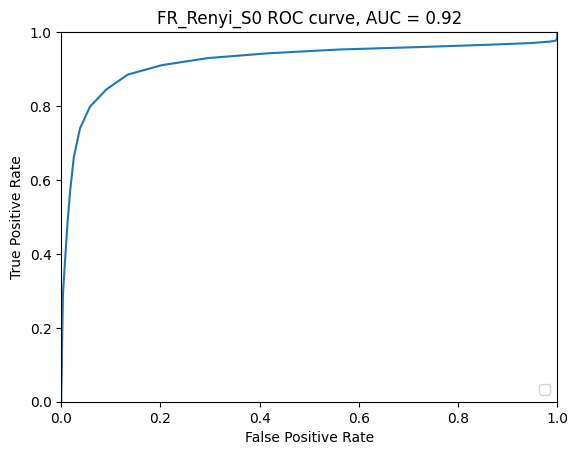

0.8574476596879582 tensor(0.3244)


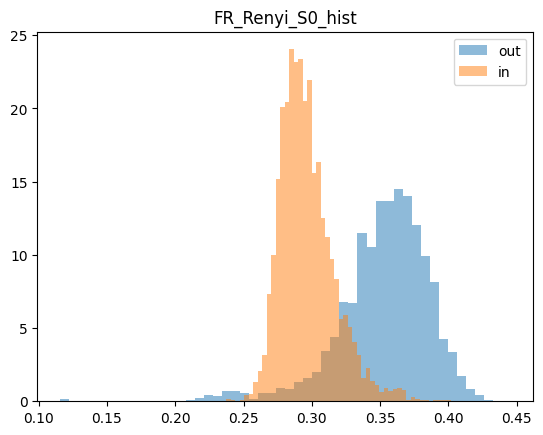

In [7]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "Renyi", "s0", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_fr_train, "Renyi", "s0", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "FR_Renyi_S0")

#### Fischer-Rao

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 238/238 [01:54<00:00,  2.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


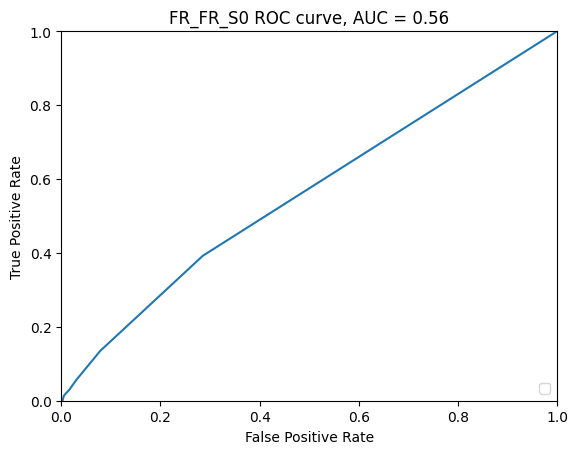

0.5908208433641375 tensor(0.7429)


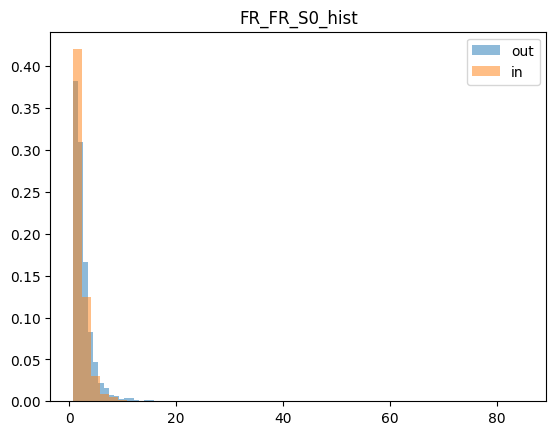

In [8]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "FR", "s0", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_fr_train, "FR", "s0", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "FR_FR_S0")

### With access to outputs of the in sample

In [9]:
model.generate_bag(loader_de_train)

Generate bag of distribution:   0%|          | 0/769 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generate bag of distribution: 100%|██████████| 769/769 [02:40<00:00,  4.80it/s]


tensor([[5.6455e-02, 1.7664e-06, 2.6444e-03,  ..., 1.7109e-06, 1.6938e-06,
         0.0000e+00],
        [9.9804e-02, 1.4398e-06, 8.4308e-04,  ..., 1.4370e-06, 1.4239e-06,
         0.0000e+00],
        [1.1775e-01, 1.8329e-06, 3.9253e-03,  ..., 1.8048e-06, 1.8425e-06,
         0.0000e+00],
        ...,
        [1.1305e-01, 1.7688e-06, 1.0493e-03,  ..., 1.6411e-06, 1.6563e-06,
         0.0000e+00],
        [1.0021e-01, 1.3020e-06, 2.0308e-04,  ..., 1.2862e-06, 1.2834e-06,
         0.0000e+00],
        [2.1943e-01, 1.4411e-06, 4.3283e-03,  ..., 1.3918e-06, 1.3978e-06,
         0.0000e+00]], device='cuda:0')

#### Rényi

Computing anomaly score for each data: 100%|██████████| 238/238 [03:22<00:00,  1.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


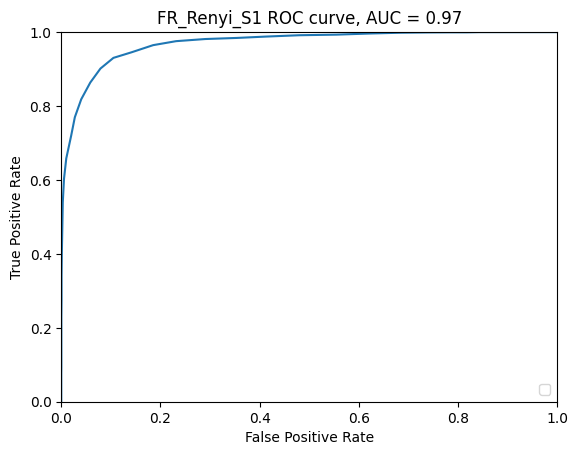

0.8965877892534971 tensor(0.2149)


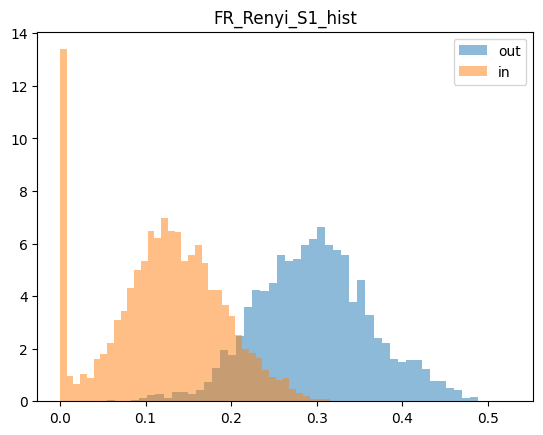

In [10]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "Renyi", "s1", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_fr_train, "Renyi", "s1", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "FR_Renyi_S1")

#### Fischer-Rao

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 238/238 [02:33<00:00,  1.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


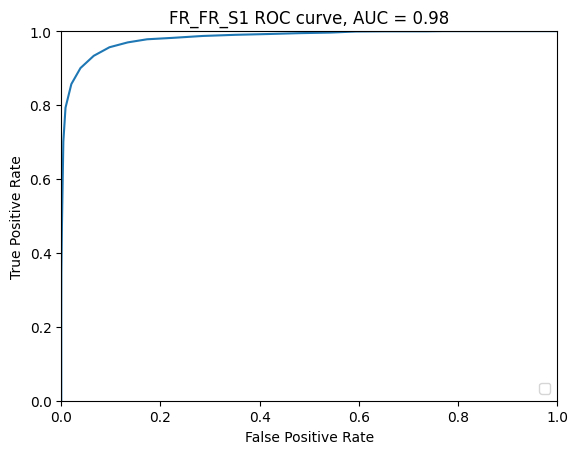

0.9221976880114301 tensor(0.5946)


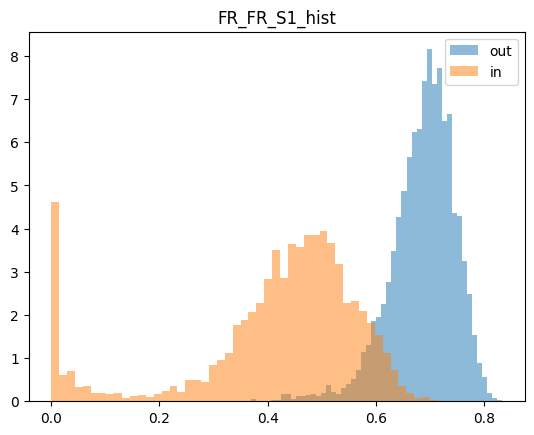

In [11]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "FR", "s1", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_fr_train, "FR", "s1", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "FR_FR_S1")

## Dutch OOD

In [12]:
del data_fr, data_fr_train, data_fr_test, loader_fr_train, loader_fr_test
del list_anomaly_in, list_anomaly_out

In [13]:
data_nld = datasets.load_dataset('Helsinki-NLP/tatoeba_mt','eng-nld',split=datasets.Split.TEST,
                                 verification_mode= datasets.VerificationMode.NO_CHECKS)\
                                    .rename_columns({'sourceLang': 'targetlang', 'targetlang': 'sourceLang',
                                                     'sourceString': 'targetString', 'targetString': 'sourceString'})

data_nld_train, data_nld_test = random_split(data_nld, [0.3, 0.7])

loader_nld_train = DataLoader(data_nld_train, batch_size=args['batch_size'], num_workers=args['num_workers'], 
                       shuffle=args['shuffle'], drop_last=args['drop_last'])

loader_nld_test = DataLoader(data_nld_test, batch_size=args['batch_size'], num_workers=args['num_workers'], 
                       shuffle=args['shuffle'], drop_last=args['drop_last'])

Found cached dataset tatoeba_mt (/home/funny_shannon/.cache/huggingface/datasets/Helsinki-NLP___tatoeba_mt/eng-nld/0.0.0/01e819f3f64a772a2ca70949061d295d3a2dc99d05183fe4776a3be23f75f619)


### With access to outputs of the in sample

#### Rényi

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 239/239 [01:42<00:00,  2.33it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


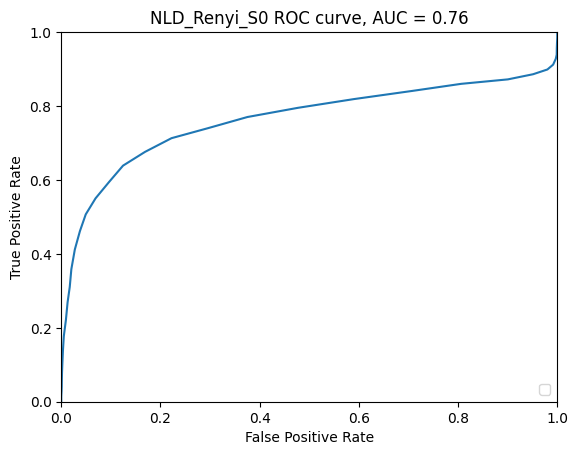

0.7080010998075337 tensor(0.3139)


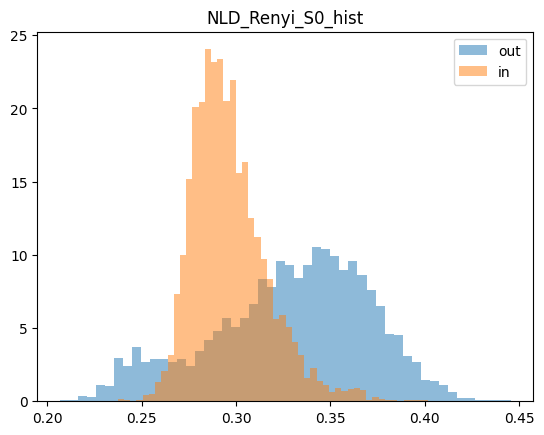

In [14]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "Renyi", "s0", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_nld_train, "Renyi", "s0", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "NLD_Renyi_S0")

#### Fischer-Rao

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 239/239 [01:48<00:00,  2.21it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


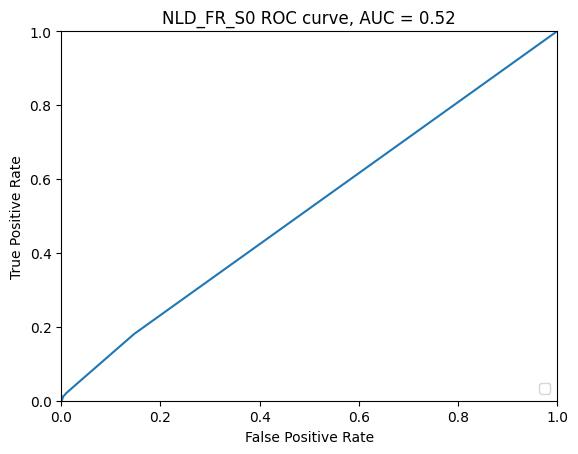

0.5911383564832777 tensor(0.7195)


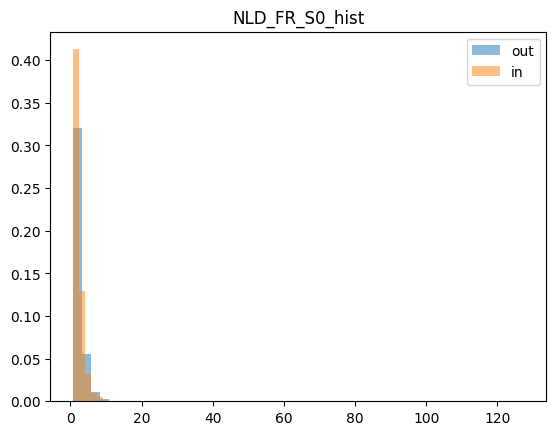

In [15]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "FR", "s0", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_nld_train, "FR", "s0", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "NLD_FR_S0")

### With access to outputs of the in sample

#### Rényi

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 239/239 [03:14<00:00,  1.23it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


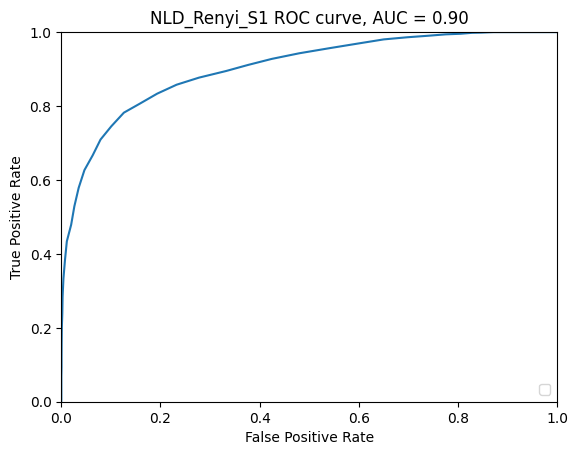

0.7994096337045484 tensor(0.1976)


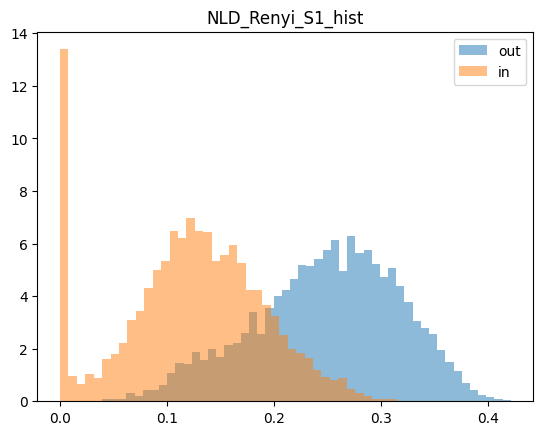

In [16]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "Renyi", "s1", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_nld_train, "Renyi", "s1", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "NLD_Renyi_S1")

#### Fischer-Rao

Computing anomaly score for each data:   0%|          | 0/330 [00:00<?, ?it/s]/home/funny_shannon/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Computing anomaly score for each data: 100%|██████████| 239/239 [02:25<00:00,  1.64it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


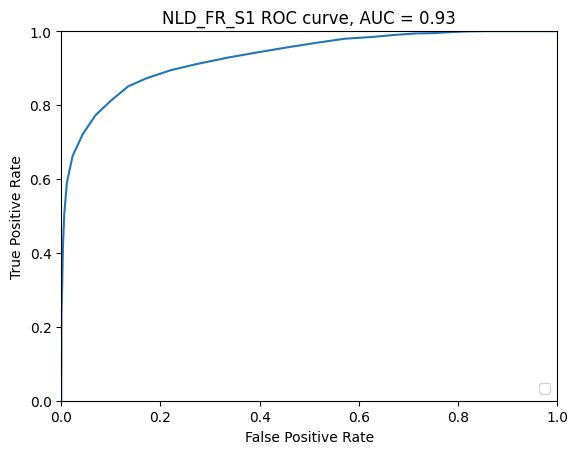

0.8351166688152636 tensor(0.5604)


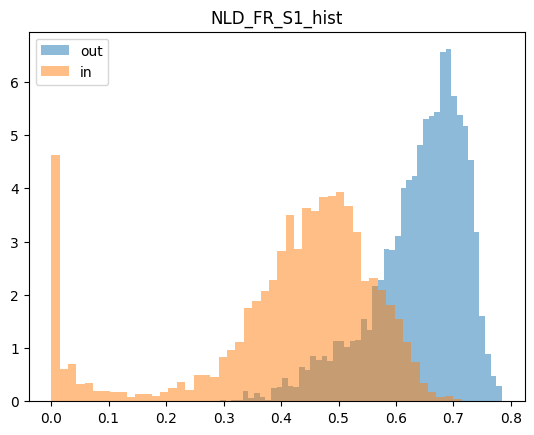

In [17]:
list_anomaly_in = model.anomaly_score_loader(loader_de_test, "FR", "s1", args["alpha"], args["temperature"])

list_anomaly_out = model.anomaly_score_loader(loader_nld_train, "FR", "s1", args["alpha"], args["temperature"])

show_gaphs(list_anomaly_in, list_anomaly_out, name = "NLD_FR_S1")